In [1]:
# todo simplify/clean

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
from tools import Agent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train
sns.set_style("darkgrid")

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
env = gym.make('CartPole-v0')

# deep Q-learning

When the state spaces is continous. It is necessary to have a function for the Q value. A common way to represent and update this function, it is to use parametric function (as neural network).
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we eant to update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y_t - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$
2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass 

In [6]:
class DeepQAgent(DeepAgent):
    def __init__(self, env, eps = 0.01, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        self.model.summary()
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_action = Input(name='input_action', shape=(self.env.action_space.n,), dtype='float32')
        xs = Dense(32, activation='relu')(input_state)
        xa = Dense(32, activation='relu')(input_action)
        x = concatenate([xs, xa])
        x = Dense(8, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = Model(inputs=[input_state,input_action], outputs=x)
        model.compile(loss='mse')
        return model
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        X_current_state = [np.tile(state, (self.env.action_space.n, 1)), np.eye(self.env.action_space.n)]
        predicted_Qs = self.model.predict(X_current_state)
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        X_next = [np.tile(next_state, (self.env.action_space.n, 1)), np.eye(self.env.action_space.n)]
        predicted_Q_nexts = self.model.predict(X_next)
        if done is True:
            target = reward
        else:
            target = reward + self.gamma * np.max(predicted_Q_nexts)
        target = np.array([target]).reshape(1,-1)
        one_hot_action = np.zeros(self.env.action_space.n)
        one_hot_action[action] = 1
        X_current_state_action = [current_state.reshape(1,-1), one_hot_action.reshape(1,-1)]
        self.model.fit(X_current_state_action, target, batch_size=1, verbose=0, shuffle=False)

In [15]:
q_agent = DeepQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 600)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_state (InputLayer)        [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_action (InputLayer)       [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           160         input_state[0][0]                
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 32)           96          input_action[0][0]               
____________________________________________________________________________________________

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7fd95dedc748>>
Traceback (most recent call last):
  File "/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow_core/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


episode: 40 - cum reward 10.0
episode: 41 - cum reward 9.0
episode: 42 - cum reward 11.0
episode: 43 - cum reward 9.0
episode: 44 - cum reward 10.0
episode: 45 - cum reward 12.0
episode: 46 - cum reward 10.0
episode: 47 - cum reward 12.0
episode: 48 - cum reward 11.0
episode: 49 - cum reward 9.0
episode: 50 - cum reward 11.0
episode: 51 - cum reward 10.0
episode: 52 - cum reward 8.0
episode: 53 - cum reward 10.0
episode: 54 - cum reward 9.0
episode: 55 - cum reward 9.0
episode: 56 - cum reward 12.0
episode: 57 - cum reward 10.0
episode: 58 - cum reward 13.0


KeyboardInterrupt: 

In [16]:
class DeepQAgentV2(DeepAgent):
    def __init__(self, env, eps = 0.01, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        self.model.summary()
        
        self.predicted_Qs = None
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
        return model
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        self.predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        action = np.argmax(self.predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        predicted_Q_nexts = self.model.predict(next_state.reshape(1, -1))[0]
        target = self.predicted_Qs
        if done is True:
            target[action] = reward
        else:
            target[action] = reward + self.gamma * np.max(predicted_Q_nexts)
        self.model.train_on_batch(current_state.reshape(1, -1), target.reshape(1, -1))
        #self.model.fit(current_state.reshape(1, -1), target.reshape(1, -1), batch_size=1, verbose=0, shuffle=False)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 11.0
episode: 1 - cum reward 10.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 10.0
episode: 4 - cum reward 10.0
episode: 5 - cum reward 11.0
episode: 6 - cum reward 8.0
episode: 7 - cum reward 9.0
episode: 8 - cum reward 10

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

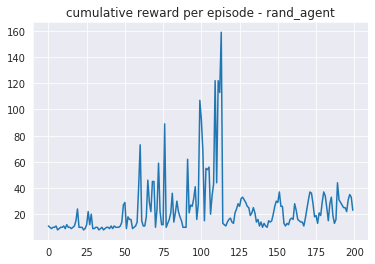

In [17]:
q_agent = DeepQAgentV2(env)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

### Experience replay

$L_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s, a; \theta_i)\right)^2 \right]$

### clipping
$Q(s,a):=Q(s,a)+\alpha(clip(r+\gamma \arg\max(Q(s',a'))-Q(s,a), -1, 1))$

In [11]:
import tensorflow.keras.backend as K

In [19]:
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, eps = 0.1, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .1, alpha = .01, memory_size = 2000, batch_size = 100):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.state_size = env.observation_space.shape[0]
        self.state_dim = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        model.compile(loss=tf.keras.losses.Huber(delta=10000.),optimizer=Adam(learning_rate=1e-2))
        #model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
        
        return model
    
    #def replay(self, batch_size):
    #    x_batch =  np.zeros((batch_size, self.state_size))
    #    y_batch =  np.zeros((batch_size, self.action_size))
    #    minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
    #    for i, (state, action, reward, next_state, done) in enumerate(minibatch):
    #        target = self.model.predict(state.reshape(1,-1))[0]
    #        if done:
    #            target[action] = reward
    #        else:
    #            target[action] = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1,-1)))
    #        x_batch[i] = state
    #        y_batch[i] = target
    #    return x_batch, y_batch
    
    def replay(self, batch_size):
        minibatch = np.array(random.sample(self.memory, min(len(self.memory), batch_size)))
        states = np.vstack(np.array(minibatch)[:,0])
        actions = np.array(minibatch)[:,1].astype(int)
        rewards = np.array(minibatch)[:,2]
        next_states = np.vstack(np.array(minibatch)[:,3])
        dones = np.array(minibatch)[:,4]
        targets = self.model.predict(states)
        targets_next = self.model.predict(next_states)
        targets[np.arange(actions.size),actions] = rewards + (1 - dones) * self.gamma * np.max(targets_next, axis=1)
        #targets[np.arange(actions.size),actions] = np.clip(rewards + (1 - dones) * self.gamma * np.max(targets_next, axis=1),-1,1)
        return states, targets
    
    
    def save_model(self, path):
        self.model.save(path)
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 8.0
episode: 1 - cum reward 10.0
episode: 2 - cum reward 10.0
episode: 3 - cum reward 10.0
episode: 4 - cum reward 11.0
episode: 5 - cum reward 16.0
episode: 6 - cum reward 15.0
episode: 7 - cum reward 19.0
episode: 8 - cum reward 

episode: 237 - cum reward 33.0
episode: 238 - cum reward 200.0
episode: 239 - cum reward 200.0
episode: 240 - cum reward 50.0
episode: 241 - cum reward 200.0
episode: 242 - cum reward 200.0
episode: 243 - cum reward 17.0
episode: 244 - cum reward 24.0
episode: 245 - cum reward 18.0
episode: 246 - cum reward 12.0
episode: 247 - cum reward 11.0
episode: 248 - cum reward 14.0
episode: 249 - cum reward 32.0
episode: 250 - cum reward 24.0
episode: 251 - cum reward 79.0
episode: 252 - cum reward 200.0
episode: 253 - cum reward 200.0
episode: 254 - cum reward 173.0
episode: 255 - cum reward 190.0
episode: 256 - cum reward 196.0
episode: 257 - cum reward 200.0
episode: 258 - cum reward 200.0
episode: 259 - cum reward 200.0
episode: 260 - cum reward 200.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 195.0
episode: 263 - cum reward 200.0
episode: 264 - cum reward 200.0
episode: 265 - cum reward 200.0
episode: 266 - cum reward 200.0
episode: 267 - cum reward 200.0
episode: 268 - cum 

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

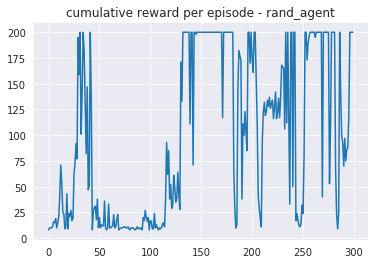

In [20]:
q_agent = DeepQAgent_experience_replay(env)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [23]:
env = gym.make('LunarLander-v2')
q_agent = DeepQAgent_experience_replay(env)
rewards = run_experiment_episode_train(env, q_agent, 600)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 132       
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward -531.6701740208835
episode: 1 - cum reward -1186.064725674252
episode: 2 - cum reward -423.37291178

episode: 162 - cum reward -426.08046793654296
episode: 163 - cum reward -697.2076241787834
episode: 164 - cum reward -982.7895184794049
episode: 165 - cum reward -375.9720203440412
episode: 166 - cum reward -331.7351898819188
episode: 167 - cum reward -428.951300918871
episode: 168 - cum reward -636.1761943893842
episode: 169 - cum reward -484.981840815643
episode: 170 - cum reward -433.10649685934766
episode: 171 - cum reward -287.97558840934016
episode: 172 - cum reward -510.796071835684
episode: 173 - cum reward -432.7086950955569
episode: 174 - cum reward -576.3020936696124


KeyboardInterrupt: 

In [9]:
np.clip(np.arange(30),-1,2)

array([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])